# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [131]:
!pip install optuna

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

### Загрузим данные и выполним их ресемплирование по одному часу

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Датасет содержит 4416 значений с марта по август включительно 2018 года.

## Анализ данных

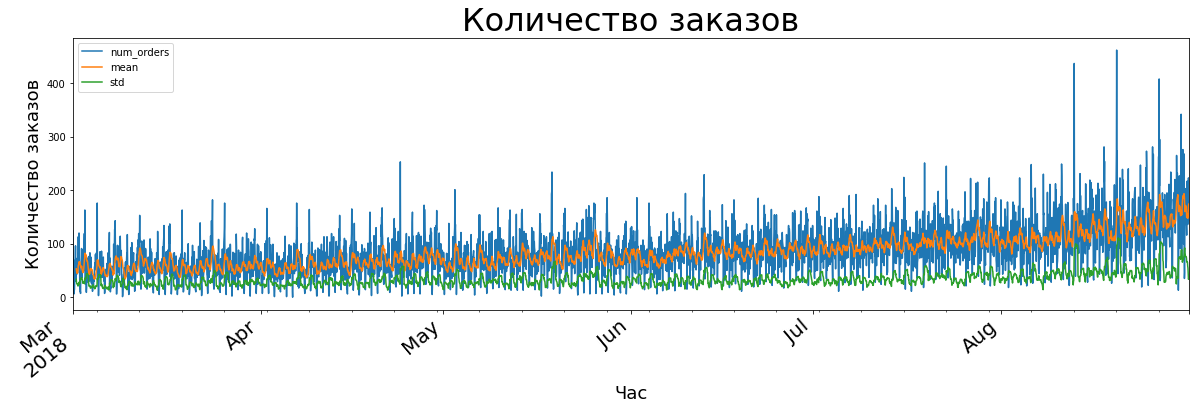

In [3]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(20, 5))
plt.title('Количество заказов', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Из графика можно сделать вывод, что временной ряд на анализируемом периоде не стационарный, потому что среднее значение и стандартное отклонение изменяются со временем.

In [4]:
data = data.drop(['mean', 'std'], axis=1)

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    # Функция для создания новых признаков
    ret_df = data.copy()
    ret_df['day'] = ret_df.index.day
    ret_df['dayofweek'] = ret_df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)

    ret_df['rolling_mean'] = ret_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return ret_df

In [47]:
def objective(trial):
    # Гиперпараметры для настройки
    max_lag = trial.suggest_int('max_lag', 1, 50)
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 1, 50)
    model_name = trial.suggest_categorical("regressor", ["LGBMRegressor", "Polynomial", "LinearRegression"])
    
    if model_name == "LGBMRegressor":
        num_leaves = trial.suggest_categorical("num_leaves", [2, 4, 8])
        model = lgb.LGBMRegressor(num_leaves=num_leaves)
    elif model_name == "Polynomial":
        degree = trial.suggest_int('degree', 3, 9)
        model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                          ('linear', LinearRegression())])
    else:
        model = LinearRegression()
    
    df = make_features(data, max_lag, rolling_mean_size)
    train, test = train_test_split(df, shuffle=False, test_size=0.2)
    train = train.dropna()
    test = test.dropna()

    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis=1)
    y_test = test['num_orders']
    X_test = test.drop('num_orders', axis=1)
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    
    return mean_squared_error(y_test_pred, y_test, squared=False)

In [48]:
sampler = TPESampler(seed=25)

In [49]:
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=20)
print("Лучшая метрика:", study.best_value)
print("Лучшие гиперпараметры:", study.best_params)

[I 2024-10-08 17:46:33,708] A new study created in memory with name: no-name-9b67e598-8440-4740-9ef3-61c6a0434d07
[I 2024-10-08 17:46:33,807] Trial 0 finished with value: 40.04023199791373 and parameters: {'max_lag': 44, 'rolling_mean_size': 30, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:46:33,928] Trial 1 finished with value: 114.94949477053953 and parameters: {'max_lag': 6, 'rolling_mean_size': 35, 'regressor': 'Polynomial', 'degree': 5}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:46:34,023] Trial 2 finished with value: 56.24985556128096 and parameters: {'max_lag': 6, 'rolling_mean_size': 23, 'regressor': 'LGBMRegressor', 'num_leaves': 4}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:46:34,083] Trial 3 finished with value: 40.04383831805514 and parameters: {'max_lag': 42, 'rolling_mean_size': 25, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 40.04023199791373.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 3509, number of used features: 9
[LightGBM] [Info] Start training from score 74.422343


[I 2024-10-08 17:46:50,934] Trial 4 finished with value: 498.42527769072143 and parameters: {'max_lag': 26, 'rolling_mean_size': 28, 'regressor': 'Polynomial', 'degree': 6}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:46:51,062] Trial 5 finished with value: 53.77889078128262 and parameters: {'max_lag': 15, 'rolling_mean_size': 46, 'regressor': 'LGBMRegressor', 'num_leaves': 8}. Best is trial 0 with value: 40.04023199791373.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 3486, number of used features: 18
[LightGBM] [Info] Start training from score 74.519507


[I 2024-10-08 17:47:19,011] Trial 6 finished with value: 175.69140360063201 and parameters: {'max_lag': 42, 'rolling_mean_size': 42, 'regressor': 'Polynomial', 'degree': 6}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:48:14,424] Trial 7 finished with value: 170.23303808325764 and parameters: {'max_lag': 48, 'rolling_mean_size': 45, 'regressor': 'Polynomial', 'degree': 7}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:48:14,465] Trial 8 finished with value: 46.66814414686887 and parameters: {'max_lag': 7, 'rolling_mean_size': 39, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:48:47,439] Trial 9 finished with value: 464.01524228324354 and parameters: {'max_lag': 26, 'rolling_mean_size': 33, 'regressor': 'Polynomial', 'degree': 5}. Best is trial 0 with value: 40.04023199791373.
[I 2024-10-08 17:48:47,559] Trial 10 finished with value: 40.46304733496179 and parameters: {'max_lag': 34, 'rolling_mean_siz

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8918
[LightGBM] [Info] Number of data points in the train set: 3483, number of used features: 52
[LightGBM] [Info] Start training from score 74.482056


[I 2024-10-08 17:48:48,758] Trial 19 finished with value: 47.39801474269781 and parameters: {'max_lag': 20, 'rolling_mean_size': 19, 'regressor': 'LinearRegression'}. Best is trial 14 with value: 37.284179794226844.


Лучшая метрика: 37.284179794226844
Лучшие гиперпараметры: {'max_lag': 48, 'rolling_mean_size': 3, 'regressor': 'LinearRegression'}


In [149]:
study.best_trial

FrozenTrial(number=89, state=TrialState.COMPLETE, values=[37.42728382952265], datetime_start=datetime.datetime(2024, 10, 8, 15, 39, 50, 341775), datetime_complete=datetime.datetime(2024, 10, 8, 15, 39, 51, 194556), params={'max_lag': 201, 'rolling_mean_size': 19, 'regressor': 'LGBMRegressor'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_lag': IntDistribution(high=300, log=False, low=1, step=1), 'rolling_mean_size': IntDistribution(high=300, log=False, low=1, step=1), 'regressor': CategoricalDistribution(choices=('LGBMRegressor',))}, trial_id=89, value=None)

In [129]:
df = make_features(data, study.best_trial.params['max_lag'], study.best_trial.params['rolling_mean_size'])
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
test = test.dropna()

y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)
y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(mean_squared_error(y_test_pred, y_test, squared=False))

31.44322175253337


In [130]:
y_test_median = np.ones(y_test.shape) * y_train.median()

print("MAE:", mean_absolute_error(y_test_median, y_test))

MAE: 58.740950226244344
